In [1]:
import  numpy               as     np
from    astropy.table       import Table
from    astropy.io          import fits
from    astropy.coordinates import SkyCoord
import  astropy.units       as     u 

import  matplotlib.pyplot   as     plt
import  matplotlib.colors   as     colors 

## preparing 3dhst & JWST catalog

In [2]:
#3d hst
cat_obj_lis = Table.read('data_3dhst/3dhst_master.phot.v4.1/3dhst_master.phot.v4.1.cat.FITS')


#jwst data
obj_lis = Table.read('spectra-fitting_selected_psfmatched.fits')
obj_lis = obj_lis#[obj_lis['field']=='uma-03']

### plot what all the fields look like

Text(0, 0.5, 'dec [deg]')

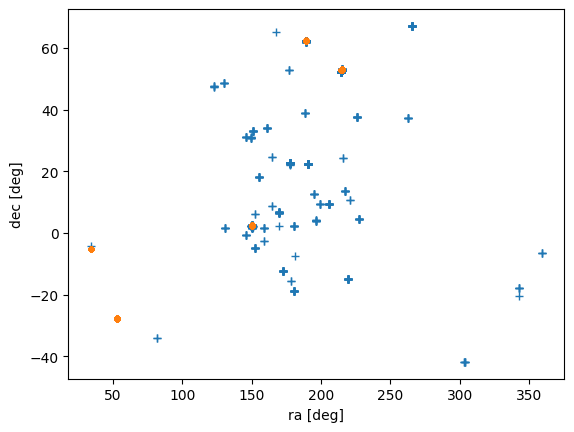

In [13]:
%matplotlib inline
plt.plot(obj_lis['ra'],obj_lis['dec'],linewidth=0,marker='+')
cat_obj_lis = Table.read('data_3dhst/3dhst_master.phot.v4.1/3dhst_master.phot.v4.1.cat.FITS')
plt.plot(cat_obj_lis ['ra'],cat_obj_lis['dec'],linewidth=0,marker='.')
plt.xlabel('ra [deg]')
plt.ylabel('dec [deg]')


# catalog crossmatching

(<Column name='field' dtype='bytes7' length=3>
  AEGIS
 COSMOS
GOODS-N, array([ 1, 23, 33]))


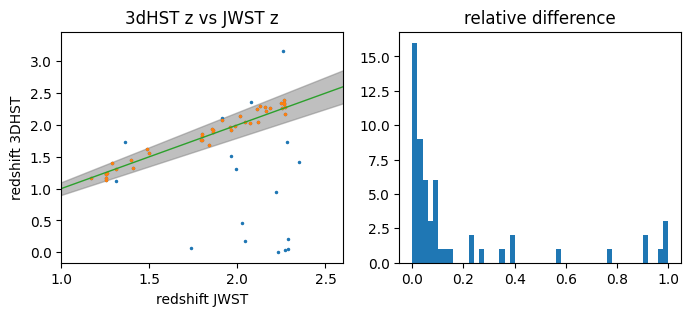

total number of objects: 692
number of matched objects: 57
number of object within 10.0% rel. error: 40
median of rel. difference: 0.05538390195977031


In [32]:
#catalog crossmatching, 
# 3DHST catalog from https://archive.stsci.edu/prepds/3d-hst/
# JWST  catalog from OUTThere and processed in previous segments.
# here 2d crossmatch is performed, 
# rule of successful crossmatch: 
#   d2d < accept_value
#further selection rule:
#   redshift rel. difference < accecpt_value%

jwst_objs = SkyCoord(ra = obj_lis['ra']*u.degree,dec=obj_lis['dec']*u.degree)
hst_objs = SkyCoord(ra = cat_obj_lis['ra']*u.degree,dec=cat_obj_lis['dec']*u.degree)
idx, d2d, d3d = jwst_objs.match_to_catalog_sky(hst_objs)


#check the properties of my crossmatch:
#  matched fields & num of objects
%matplotlib inline
match_rule = d2d.to(u.deg).value < 0.1/3600
cat_obj_matched = cat_obj_lis[idx][match_rule]
obj_matched     = obj_lis[match_rule]
print(np.unique(cat_obj_matched['field'],return_counts=True))

#plt.plot(cat_obj_matched['ra'],cat_obj_matched['dec'],linewidth=0,alpha=0.5,marker='.')
#plt.plot(obj_matched['ra'],obj_matched['dec'],linewidth=0,alpha=0.5,marker='+')



#here check the redshift of 2 catalogs & the 2nd selection rule of rel. difference in redshift
cat_z = np.where(cat_obj_matched['z_spec']!=-1,cat_obj_matched['z_spec'],cat_obj_matched['z_peak'])
rel_diff = np.abs(cat_z-obj_matched['redshift'])/obj_matched['redshift']#cat_obj_matched['z_peak']
accept= 0.1
select =  np.abs(rel_diff)<accept


x = np.linspace(0,3,10)
x_lo=x*(1-accept);x_up=x*(1+accept)
ax = plt.figure(figsize=(8,3))
ax.add_subplot(121)
#plots redshift jwst vs redshif hst
plt.plot(obj_matched['redshift'],cat_z,linewidth=0,marker='.',markersize=3)
plt.plot(obj_matched['redshift'][select],cat_z[select],linewidth=0,marker='.',markersize=3)
plt.plot(x,x,linewidth=1)
plt.fill_between(x, x_lo, x_up, color="gray", alpha=0.5, label="10% Error")  # 灰色误差区间
plt.xlabel('redshift JWST');plt.ylabel('redshift 3DHST')
plt.xlim(1.0,2.6)
plt.title('3dHST z vs JWST z')

ax.add_subplot(122)
#rel. difference
plt.hist(rel_diff,bins=50)
plt.title('relative difference')
plt.show()

print('total number of objects:',len(obj_lis))
print('number of matched objects:',len(obj_matched))
print(f'number of object within {accept*100}% rel. error:',len(obj_matched[select]))
print('median of rel. difference:',np.median(rel_diff))

#save the crossmatch catalog into one fits list
cross_match = fits.HDUList()
cross_match.append(fits.BinTableHDU(obj_matched[select],name='JWST_CROSSMATCH'))
cross_match.append(fits.BinTableHDU(cat_obj_matched[select],name='3DHST_CROSSMATCH'))
cross_match.writeto('JWST_HST_catalog_crossmatched.fits',overwrite=True)

### read SFR catalog & SFMS

/tmp/ipykernel_113161/3517093236.py:11: RuntimeWarning: invalid value encountered in log10
  plt.plot(cat_obj_matched['lmass'][select],np.log10(cat_obj_matched['sfr'][select]),linewidth=0,marker='+')


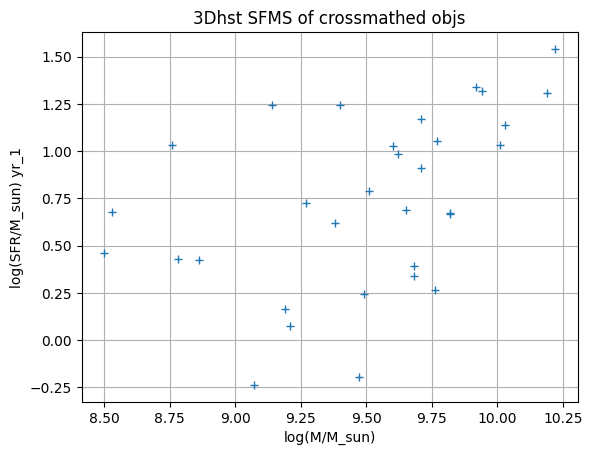

In [31]:
#read SFR from SFR catalog of individual fields,
#data available at https://archive.stsci.edu/prepds/3d-hst/
sfr_field_name={'AEGIS':'aegis','COSMOS':'cosmos','GOODS-N':'goodsn'}
sfr_lis = []
for obj in cat_obj_matched:
    sfr_file = np.loadtxt(f"data_3dhst/sfr_3dhst.v4.1/{sfr_field_name[obj['field']]}_3dhst.v4.1.sfr")
    sfr_lis.append(sfr_file[sfr_file[:,0]==obj['id']][0][2])
sfr_lis = np.array(sfr_lis)
cat_obj_matched['sfr'] = sfr_lis

plt.plot(cat_obj_matched['lmass'][select],np.log10(cat_obj_matched['sfr'][select]),linewidth=0,marker='+')
plt.xlabel('log(M/M_sun)')
plt.ylabel('log(SFR/M_sun) yr_-1')
plt.grid()
plt.title('3Dhst SFMS of crossmathed objs')
plt.show()
#plt.plot(cat_obj_matched['lmass'],np.log10(cat_obj_matched['sfr']),linewidth=0,marker='+')

#plt.xlim(8.5,11);plt.ylim(0,2.5)

In [7]:
obj_matched[select]['flux_Ha']

6.5e-17
9.3e-17
3.4e-17
1.7e-16
6.9e-17
2.8e-17
8.2e-18
7.1e-17
8.0e-17
5.4e-18
5.6e-17


## ongoing part--------------------------------------------------------------------

this is a small attempt to get the theoretical model of SFR vs Mass from [Whitaker 2014](https://iopscience.iop.org/article/10.1088/0004-637X/795/2/104/pdfhttps://iopscience.iop.org/article/10.1088/0004-637X/795/2/104/pdf)

still under construction

array(-0.97726131)

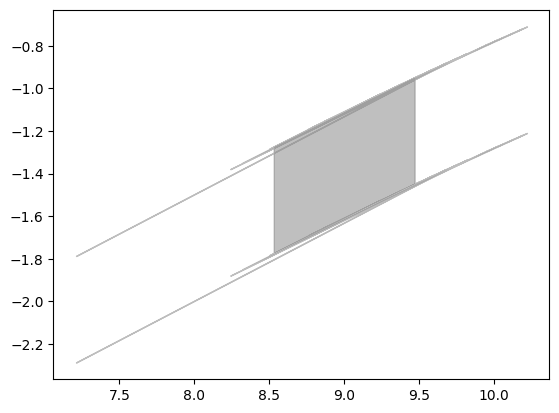

In [8]:
#========================ongoing=========================
import numpy as np

# parameter from the paper
#         log(a) log(a_err)   b b_err
params = {
    (9.2, 9.4): (-9.54, 0.15, 1.95, 0.24),
    (9.4, 9.6): (-9.50, 0.14, 1.86, 0.22),
    (9.6, 9.8): (-9.54, 0.07, 1.90, 0.12),
    (9.8, 10.0): (-9.58, 0.03, 1.98, 0.04),
    (10.0, 10.2): (-9.69, 0.03, 2.16, 0.04),
    (10.2, 10.4): (-9.93, 0.08, 2.63, 0.12),
    (10.4, 10.6): (-10.11, 0.10, 2.88, 0.16),
    (10.6, 10.8): (-10.28, 0.15, 3.03, 0.24),
    (10.8, 11.0): (-10.53, 0.17, 3.37, 0.26),
    (11.0, 11.2): (-10.65, 0.11, 3.45, 0.17),
}

# sfr_m function, input: redshift z, log(m/msun) logm
#return log(psi/m_sun)
def log_sfr_m(z, logm):
    # a, b
    for (m_min, m_max), (a, a_err, b, b_err) in params.items():
        if m_min <= logm < m_max:
            break
    
    # SFR
    sfr = a + b* np.log(1+z) + logm 
    sfr_err = (a_err**2 + ((1+z)*b_err)**2)**0.5

    return np.array(sfr)


m = cat_obj_matched['lmass'][select]
sfr_1_l = log_sfr_m(m,1.1)
sfr_1_h = log_sfr_m(m,1.6)

sfr_2_l = log_sfr_m(m,1.55)
sfr_2_h = log_sfr_m(m,1.6)

plt.fill_between(m, sfr_1_l,sfr_1_h, color="gray", alpha=0.5, label="10% Error")  # 灰色误差区间

log_sfr_m(10,1.4)

In [9]:
cat_obj_matched['lmass'][select]

9.47
8.86
9.16
9.51
9.36
9.68
7.21
9.71
9.82
8.24
9.76
